Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Spleen 3D segmentation with MONAI

This tutorial demonstrates how MONAI can be used in conjunction with the [PyTorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning) framework.

We demonstrate use of the following MONAI features:
1. Transforms for dictionary format data.
1. Loading Nifti images with metadata.
1. Add channel dim to the data if no channel dimension.
1. Scaling medical image intensity with expected range.
1. Croping out a batch of balanced images based on  the positive / negative label ratio.
1. Cache IO and transforms to accelerate training and validation.
1. Use of a a 3D UNet model, Dice loss function, and mean Dice metric for a 3D segmentation task.
1. The sliding window inference method.
1. Deterministic training for reproducibility.

The Spleen dataset can be downloaded from http://medicaldecathlon.com/.

![spleen](http://medicaldecathlon.com/img/spleen0.png)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d_lightning.ipynb)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
!pip install -q pytorch-lightning~=2.0
%matplotlib inline

## Setup imports

In [1]:
import pytorch_lightning
from monai.utils import set_determinism
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureType,
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, list_data_collate, decollate_batch, DataLoader
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 1.3.0
Numpy version: 1.26.4
Pytorch version: 2.2.2+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home/<username>/RiSA_S3/3D_segmentation/.venv/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 10.3.0
Tensorboard version: 2.16.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.2+cu121
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
p

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp0d8k1vgc


In [8]:
data_dir = '/home/gasyna/RiSA_S3/3D_segmentation/AeroPath'

## Download dataset

Downloads and extracts the dataset.
The dataset comes from http://medicaldecathlon.com/.

In [5]:
resource = "https://zenodo.org/records/10069289/files/AeroPath.zip?download=1"
md5 = "3fd5106c175c85d60eaece220f5dfd87"

compressed_file = os.path.join(root_dir, "AeroPath.zip")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

AeroPath.zip: 4.70GB [30:59, 2.71MB/s]                               

2024-04-13 12:01:24,424 - INFO - Downloaded: /tmp/tmp0d8k1vgc/AeroPath.zip


2024-04-13 12:01:36,650 - INFO - Verified 'AeroPath.zip', md5: 3fd5106c175c85d60eaece220f5dfd87.
2024-04-13 12:01:36,651 - INFO - Writing into directory: /tmp/tmp0d8k1vgc.


In [4]:
# resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
# md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

# compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
# data_dir = os.path.join(root_dir, "Task09_Spleen")
# if not os.path.exists(data_dir):
#     download_and_extract(resource, compressed_file, root_dir, md5)

Task09_Spleen.tar: 1.50GB [10:14, 2.62MB/s]                               

2024-04-12 23:53:26,970 - INFO - Downloaded: /tmp/tmp001yf2ki/Task09_Spleen.tar


2024-04-12 23:53:29,835 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2024-04-12 23:53:29,837 - INFO - Writing into directory: /tmp/tmp001yf2ki.


## Define the LightningModule

The LightningModule contains a refactoring of your training code. The following module is a refactoring of the code in `spleen_segmentation_3d.ipynb`:

In [19]:
sorted(glob.glob(os.path.join('/home/gasyna/RiSA_S3/3D_segmentation/tmp001yf2ki/Task09_Spleen', "imagesTr", "*.nii.gz")))

pattern = os.path.join(data_dir, '**/*_CT_HR_label_airways.nii.gz')
labels = sorted(glob.glob(pattern, recursive=True))

pattern = os.path.join(data_dir, '**/*_CT_HR.nii.gz')
airways = sorted(glob.glob(pattern, recursive=True))


['/home/gasyna/RiSA_S3/3D_segmentation/AeroPath/1/1_CT_HR.nii.gz',
 '/home/gasyna/RiSA_S3/3D_segmentation/AeroPath/10/10_CT_HR.nii.gz',
 '/home/gasyna/RiSA_S3/3D_segmentation/AeroPath/11/11_CT_HR.nii.gz',
 '/home/gasyna/RiSA_S3/3D_segmentation/AeroPath/12/12_CT_HR.nii.gz',
 '/home/gasyna/RiSA_S3/3D_segmentation/AeroPath/13/13_CT_HR.nii.gz',
 '/home/gasyna/RiSA_S3/3D_segmentation/AeroPath/14/14_CT_HR.nii.gz',
 '/home/gasyna/RiSA_S3/3D_segmentation/AeroPath/15/15_CT_HR.nii.gz',
 '/home/gasyna/RiSA_S3/3D_segmentation/AeroPath/16/16_CT_HR.nii.gz',
 '/home/gasyna/RiSA_S3/3D_segmentation/AeroPath/17/17_CT_HR.nii.gz',
 '/home/gasyna/RiSA_S3/3D_segmentation/AeroPath/18/18_CT_HR.nii.gz',
 '/home/gasyna/RiSA_S3/3D_segmentation/AeroPath/19/19_CT_HR.nii.gz',
 '/home/gasyna/RiSA_S3/3D_segmentation/AeroPath/2/2_CT_HR.nii.gz',
 '/home/gasyna/RiSA_S3/3D_segmentation/AeroPath/20/20_CT_HR.nii.gz',
 '/home/gasyna/RiSA_S3/3D_segmentation/AeroPath/21/21_CT_HR.nii.gz',
 '/home/gasyna/RiSA_S3/3D_segmentation

In [20]:
class Net(pytorch_lightning.LightningModule):
    def __init__(self):
        super().__init__()
        self._model = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=2,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            norm=Norm.BATCH,
        )
        self.loss_function = DiceLoss(to_onehot_y=True, softmax=True)
        self.post_pred = Compose([EnsureType("tensor", device="cpu"), AsDiscrete(argmax=True, to_onehot=2)])
        self.post_label = Compose([EnsureType("tensor", device="cpu"), AsDiscrete(to_onehot=2)])
        self.dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
        self.best_val_dice = 0
        self.best_val_epoch = 0
        self.validation_step_outputs = []

    def forward(self, x):
        return self._model(x)

    def prepare_data(self):
        # set up the correct data path
        #train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
        #train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))

        pattern = os.path.join(data_dir, '**/*_CT_HR_label_airways.nii.gz')
        train_labels = sorted(glob.glob(pattern, recursive=True))

        pattern = os.path.join(data_dir, '**/*_CT_HR.nii.gz')
        train_images = sorted(glob.glob(pattern, recursive=True))

        data_dicts = [
            {"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)
        ]
        train_files, val_files = data_dicts[:-9], data_dicts[-9:]

        # set deterministic training for reproducibility
        set_determinism(seed=0)

        # define the data transforms
        train_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                EnsureChannelFirstd(keys=["image", "label"]),
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                Spacingd(
                    keys=["image", "label"],
                    pixdim=(1.5, 1.5, 2.0),
                    mode=("bilinear", "nearest"),
                ),
                ScaleIntensityRanged(
                    keys=["image"],
                    a_min=-57,
                    a_max=164,
                    b_min=0.0,
                    b_max=1.0,
                    clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image"),
                # randomly crop out patch samples from
                # big image based on pos / neg ratio
                # the image centers of negative samples
                # must be in valid image area
                RandCropByPosNegLabeld(
                    keys=["image", "label"],
                    label_key="label",
                    spatial_size=(96, 96, 96),
                    pos=1,
                    neg=1,
                    num_samples=4,
                    image_key="image",
                    image_threshold=0,
                ),
                # user can also add other random transforms
                #                 RandAffined(
                #                     keys=['image', 'label'],
                #                     mode=('bilinear', 'nearest'),
                #                     prob=1.0,
                #                     spatial_size=(96, 96, 96),
                #                     rotate_range=(0, 0, np.pi/15),
                #                     scale_range=(0.1, 0.1, 0.1)),
            ]
        )
        val_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                EnsureChannelFirstd(keys=["image", "label"]),
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                Spacingd(
                    keys=["image", "label"],
                    pixdim=(1.5, 1.5, 2.0),
                    mode=("bilinear", "nearest"),
                ),
                ScaleIntensityRanged(
                    keys=["image"],
                    a_min=-57,
                    a_max=164,
                    b_min=0.0,
                    b_max=1.0,
                    clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image"),
            ]
        )

        # we use cached datasets - these are 10x faster than regular datasets
        self.train_ds = CacheDataset(
            data=train_files,
            transform=train_transforms,
            cache_rate=1.0,
            num_workers=4,
        )
        self.val_ds = CacheDataset(
            data=val_files,
            transform=val_transforms,
            cache_rate=1.0,
            num_workers=4,
        )

    #         self.train_ds = monai.data.Dataset(
    #             data=train_files, transform=train_transforms)
    #         self.val_ds = monai.data.Dataset(
    #             data=val_files, transform=val_transforms)

    def train_dataloader(self):
        train_loader = DataLoader(
            self.train_ds,
            batch_size=2,
            shuffle=True,
            num_workers=4,
            collate_fn=list_data_collate,
        )
        return train_loader

    def val_dataloader(self):
        val_loader = DataLoader(self.val_ds, batch_size=1, num_workers=4)
        return val_loader

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self._model.parameters(), 1e-4)
        return optimizer

    def training_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        tensorboard_logs = {"train_loss": loss.item()}
        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)
        loss = self.loss_function(outputs, labels)
        outputs = [self.post_pred(i) for i in decollate_batch(outputs)]
        labels = [self.post_label(i) for i in decollate_batch(labels)]
        self.dice_metric(y_pred=outputs, y=labels)
        d = {"val_loss": loss, "val_number": len(outputs)}
        self.validation_step_outputs.append(d)
        return d

    def on_validation_epoch_end(self):
        val_loss, num_items = 0, 0
        for output in self.validation_step_outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]
        mean_val_dice = self.dice_metric.aggregate().item()
        self.dice_metric.reset()
        mean_val_loss = torch.tensor(val_loss / num_items)
        tensorboard_logs = {
            "val_dice": mean_val_dice,
            "val_loss": mean_val_loss,
        }
        if mean_val_dice > self.best_val_dice:
            self.best_val_dice = mean_val_dice
            self.best_val_epoch = self.current_epoch
        print(
            f"current epoch: {self.current_epoch} "
            f"current mean dice: {mean_val_dice:.4f}"
            f"\nbest mean dice: {self.best_val_dice:.4f} "
            f"at epoch: {self.best_val_epoch}"
        )
        self.validation_step_outputs.clear()  # free memory
        return {"log": tensorboard_logs}

## Run the training

In [21]:
# initialise the LightningModule
net = Net()

# set up loggers and checkpoints
log_dir = os.path.join(root_dir, "logs")
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(save_dir=log_dir)

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    devices=[0],
    max_epochs=600,
    logger=tb_logger,
    enable_checkpointing=True,
    num_sanity_val_steps=1,
    log_every_n_steps=16,
)

# train
trainer.fit(net)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/gasyna/RiSA_S3/3D_segmentation/.venv/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)
Loading dataset: 100%|██████████| 9/9 [00:32<00:00,  3.65s/it]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type     | Params
-------------------------------------------
0 | _model        | UNet     | 4.8 M 
1 | loss_function | DiceLoss | 0     
-------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.236    Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.49it/s]current epoch: 0 current mean dice: 0.0042
best mean dice: 0.0042 at epoch: 0


/home/gasyna/RiSA_S3/3D_segmentation/.venv/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 9/9 [00:04<00:00,  2.22it/s, v_num=2]current epoch: 0 current mean dice: 0.0026
best mean dice: 0.0042 at epoch: 0
Epoch 1: 100%|██████████| 9/9 [00:04<00:00,  2.24it/s, v_num=2]current epoch: 1 current mean dice: 0.0029
best mean dice: 0.0042 at epoch: 0
Epoch 2: 100%|██████████| 9/9 [00:04<00:00,  2.07it/s, v_num=2]current epoch: 2 current mean dice: 0.0036
best mean dice: 0.0042 at epoch: 0
Epoch 3: 100%|██████████| 9/9 [00:04<00:00,  1.83it/s, v_num=2]current epoch: 3 current mean dice: 0.0041
best mean dice: 0.0042 at epoch: 0
Epoch 4: 100%|██████████| 9/9 [00:05<00:00,  1.78it/s, v_num=2]current epoch: 4 current mean dice: 0.0044
best mean dice: 0.0044 at epoch: 4
Epoch 5: 100%|██████████| 9/9 [00:05<00:00,  1.77it/s, v_num=2]current epoch: 5 current mean dice: 0.0046
best mean dice: 0.0046 at epoch: 5
Epoch 6: 100%|██████████| 9/9 [00:04<00:00,  1.81it/s, v_num=2]current epoch: 6 current mean dice: 0.0054
best mean dice: 0.0054 at epoch: 6
Epoch 7: 100%

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 599: 100%|██████████| 9/9 [00:18<00:00,  0.49it/s, v_num=2]


In [22]:
print(f"train completed, best_metric: {net.best_val_dice:.4f} " f"at epoch {net.best_val_epoch}")

train completed, best_metric: 0.7979 at epoch 597


## View training in tensorboard

Please uncomment the following cell to load tensorboard results.

In [23]:
%load_ext tensorboard
%tensorboard --logdir=$log_dir

## Check best model output with the input image and label

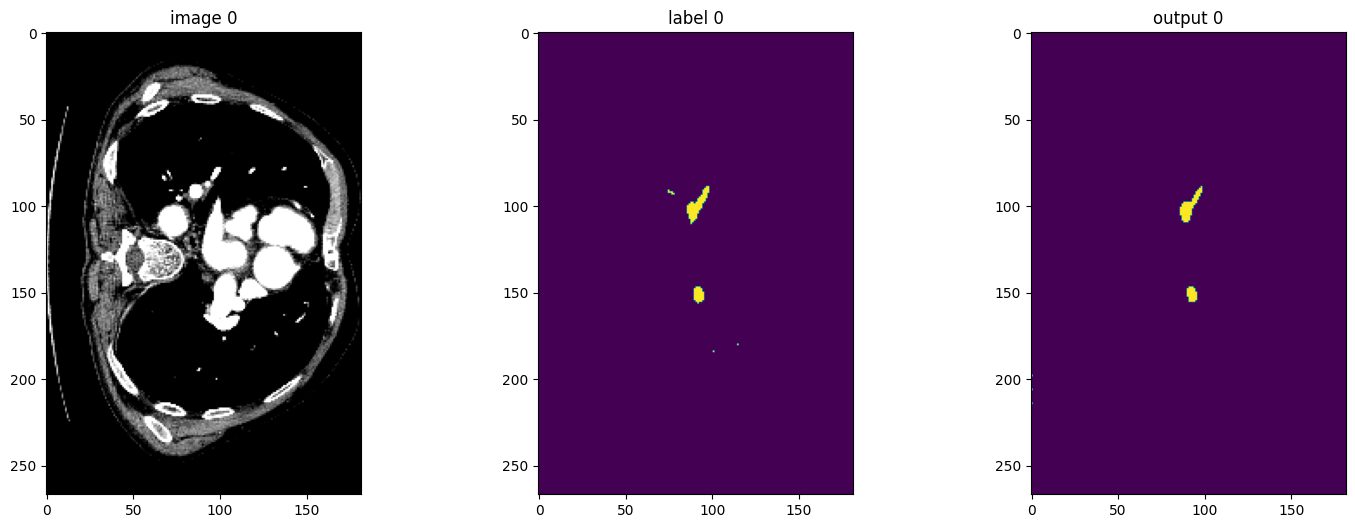

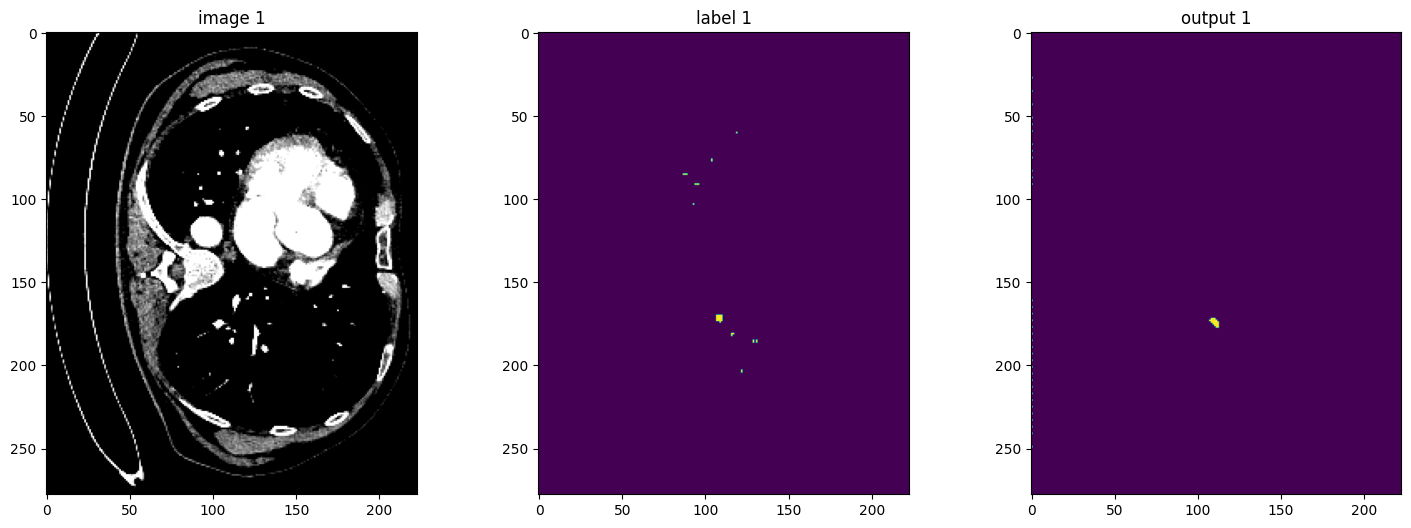

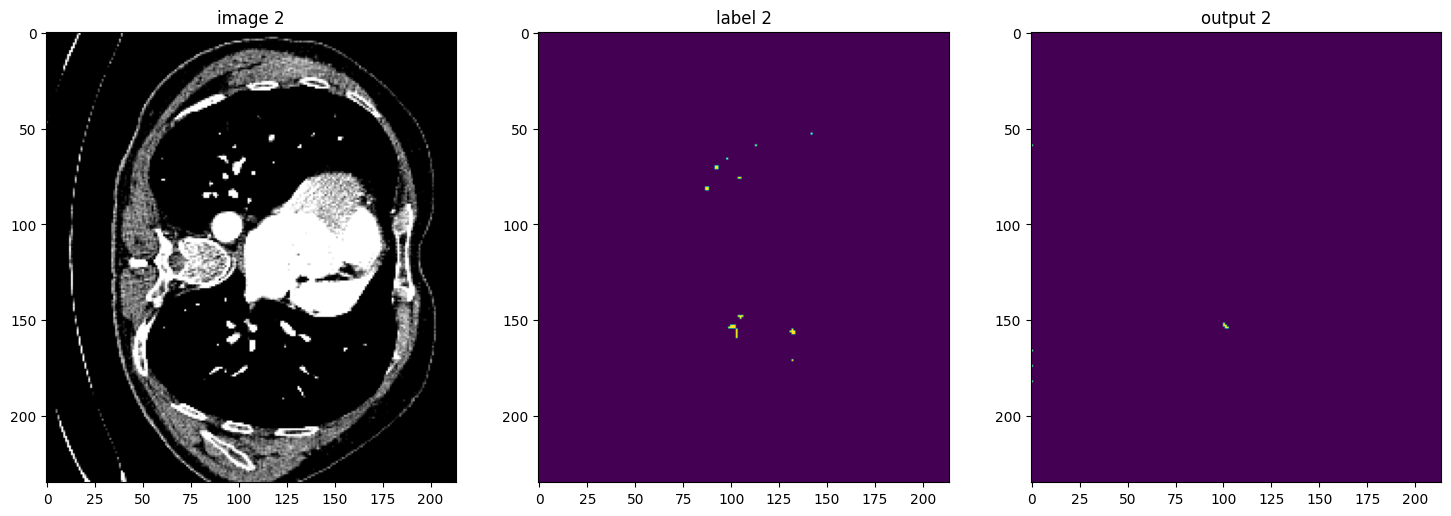

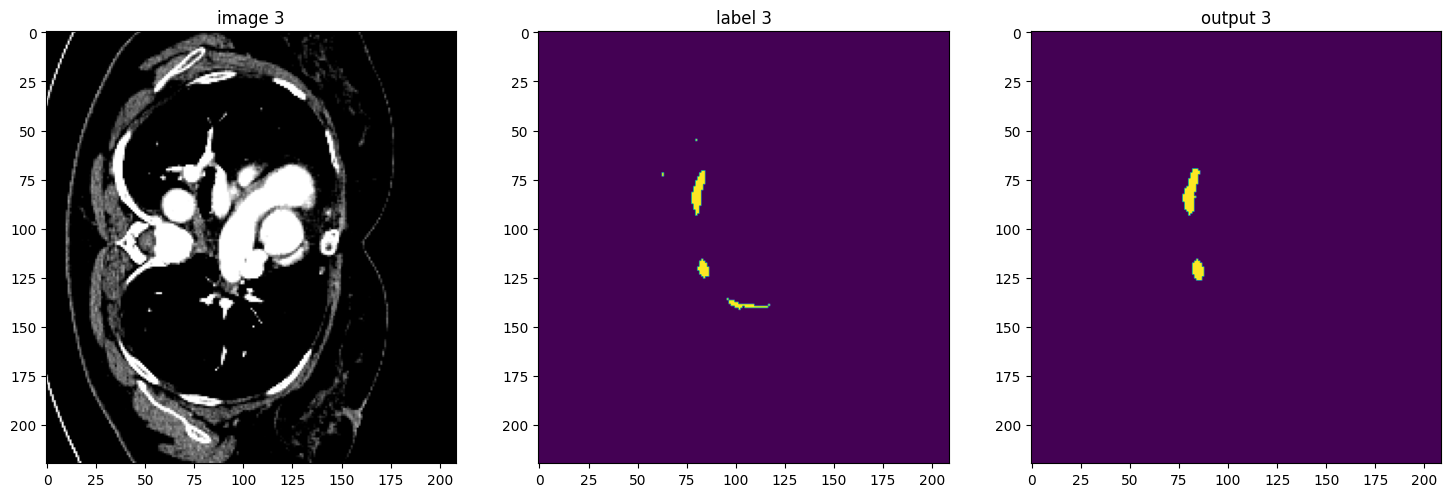

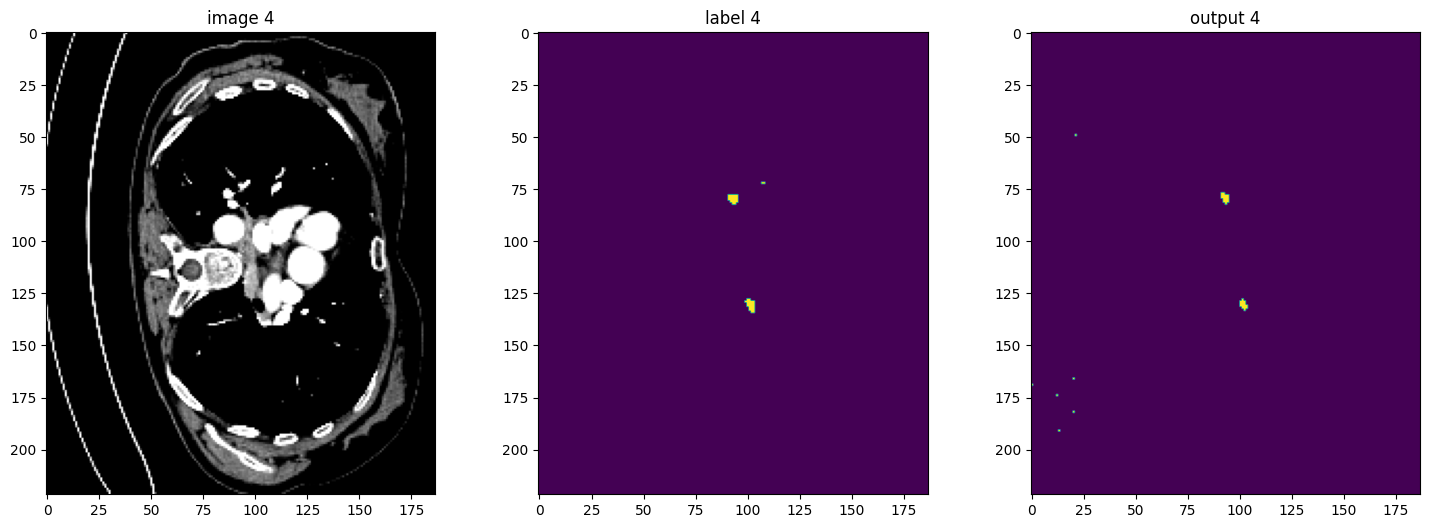

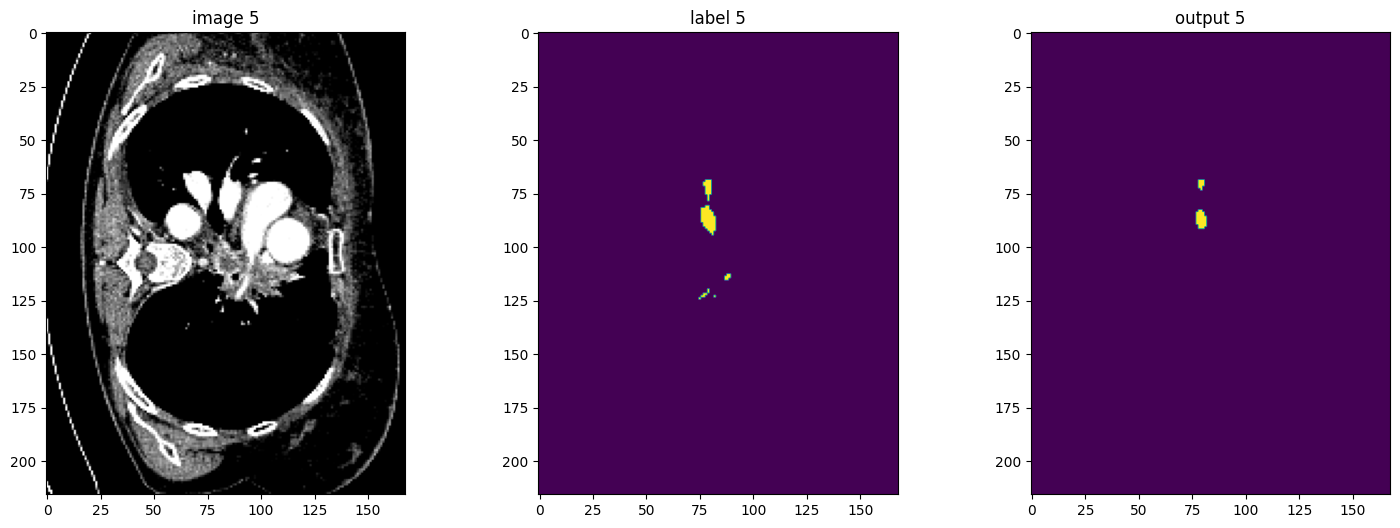

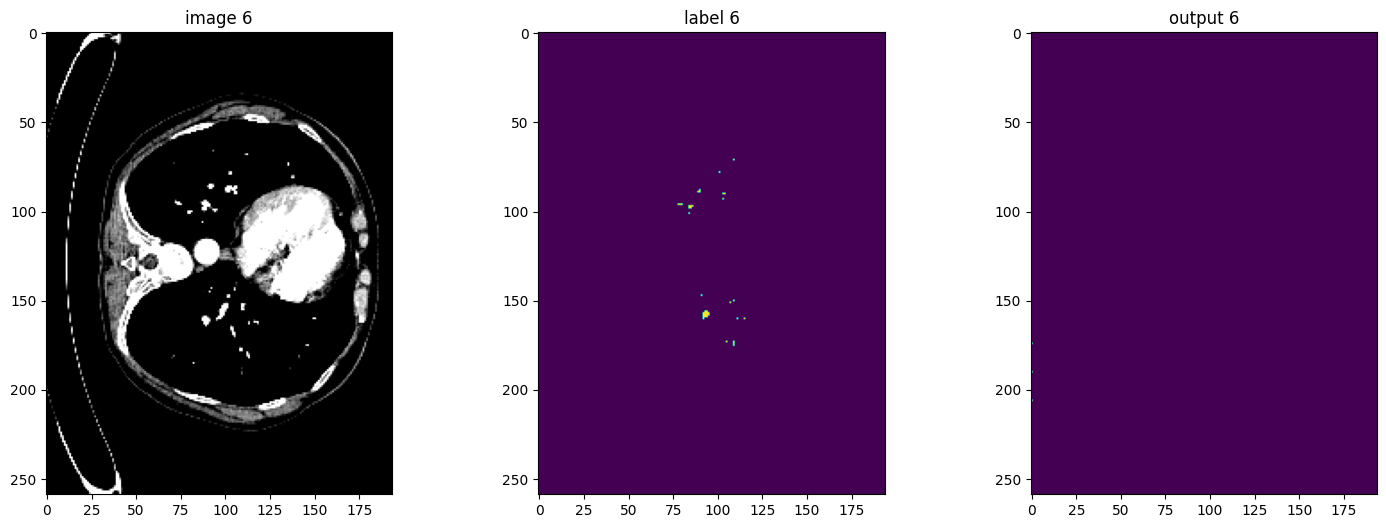

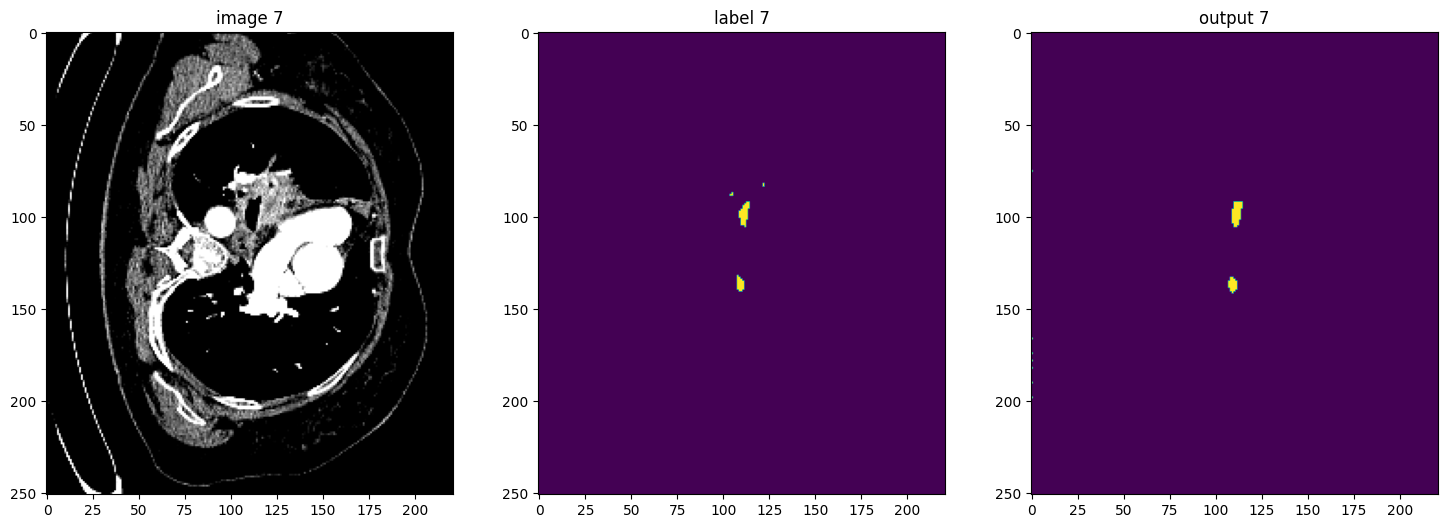

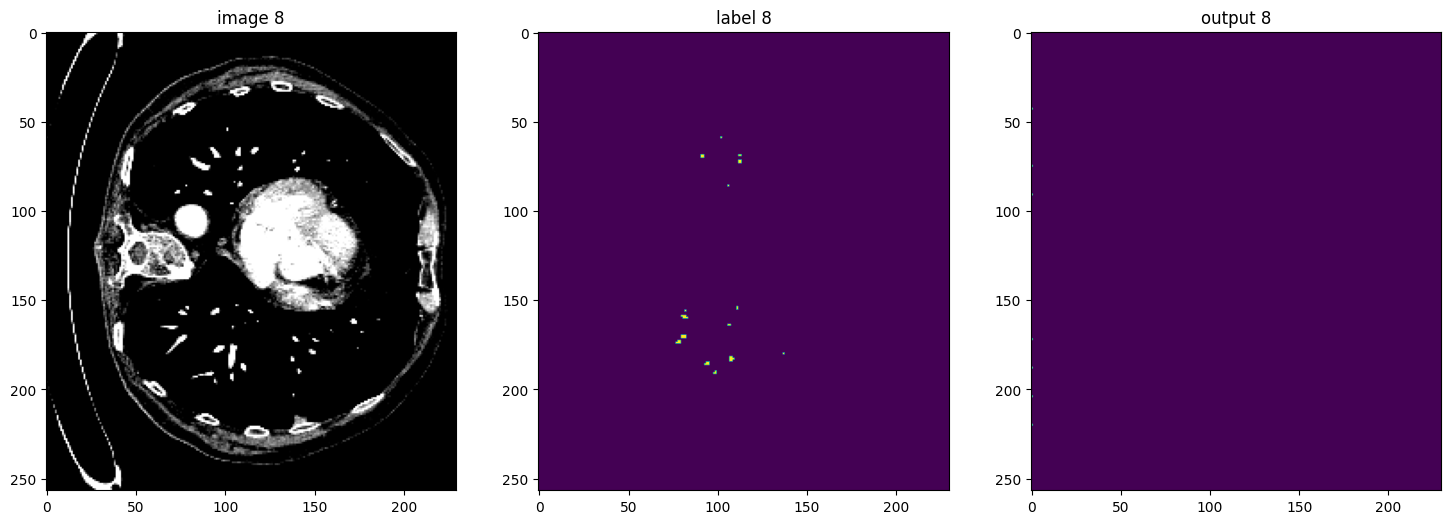

In [24]:
net.eval()
device = torch.device("cuda:0")
net.to(device)
with torch.no_grad():
    for i, val_data in enumerate(net.val_dataloader()):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, net)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)